Created: 4/3/24
Updated: 4/3/24
Author: Nicholas Ackerman
Purpose: Mix Rate BNC Retention analysis that utilzies combinations and timeframes to produce detailed chart of the most and least impactful segments on 30 and 60 day retention rates. The idea of this program will be to have the user submit multiple imputs
[timeframe, segmentation level, segments, etc] and have the mix rate calcualtion be completed at the level intentended. The program reaches out to Snowflake to pull in raw data from the ESA_MIX_RATE_SEGMENTATION table. 

In [32]:
#import libraries
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from datetime import datetime, timezone, timedelta
from itertools import combinations
from itertools import permutations
import datetime as dt
import random
import pandas as pd
import numpy as np
from snowflake.connector.pandas_tools import pd_writer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#Link to Documentation

In [33]:
#Connection setup and functions
class SFConnection:
    def __init__(self):
        self.name = ''
        self.connection = ''
        self.engine = ''

    def open_conn(self):
        username = self.name + '@safeway.com'
        account_identifier = 'abs_itds_prd.west-us-2.privatelink'

        # Create an engine to connect to Snowflake
        self.engine = create_engine(
        f'snowflake://{username}@{account_identifier}/?authenticator=externalbrowser'
        )
        self.connection = self.engine.connect()
        print("Connection Opened")

    def test_conn(self):
        try:
            self.open_conn()
            results = self.connection.execute('select current_version()').fetchone()
            print("Snowflake connected to Version: {}".format(results[0]))
            return("CONNECTED")
        except Exception as e:
            print("Snowflake connection Error")
            return("ERR")

    def run_query(self, sql):
        self.connection.execute("BEGIN")
        self.connection.execute(sql)
        self.connection.execute("COMMIT")

    def query_to_df(self, sql):
        results = self.connection.execute(sql).fetchall()
        columns = results[0].keys()
        return pd.DataFrame(results, columns=columns)
        
    def close_conn(self):
        self.connection.close()
        self.engine.dispose()
        print("Connection Closed")

    def add_name(self, name):
        self.name = name
    
    #accepts a dataframe and a table name in lowercase. It is fixed currently to the FBI Schema. You only need to pass through the tablename
    #The df must be in the exact format as table
    #This will upload in chuncks of 10,000 rows to Snowflake
    #This method will replace all current values from Dataframe 
    def load_dataframe_REPLACE(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='replace', index=False, chunksize=10000)
    
    #Method for inserting value without replacing to data tables 
    def load_dataframe_APPEND(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='append', index=False, chunksize=10000)

In [49]:
#--Query needed for Proactive Communication to show the difference in 30 day retention before and after Proactive went live. Specifically in Jewel Osco
'''
Digitial Engagement Metrics: "EDM_BIZOPS_PRD"."FBI"."HB_ECOM_DATA_L12W_DE_METRICS"
'''

SQL_TIMEFRAME_INITAL = '''
select 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
mrs.DIVISION,
mrs.URBANICITY,
--CASE WHEN FRST_TXN_SAVE20_PROMO_CODE_FLAG > 0 or FRST_TXN_SAVE30_PROMO_CODE_FLAG > 0 OR CYBER_CODE > 0 THEN 'USED PROMO CODE' else 'DID NOT USE PROMO CODE' end as Promo_usage,
count(distinct household_id) as Total_Households,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) as Repeat_30_day,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_30_DAY,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) as Repeat_60_day,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_60_DAY
from "EDM_BIZOPS_PRD"."FBI"."ESA_MIX_RATE_SEGMENTATION" mrs
left join "EDM_BIZOPS_PRD"."FBI"."ESA_HOLISTIC_SCORECARD_TXN_CUSTOMER_SEGMENT" cs
on mrs.txn_id = cs.txn_id
WHERE 
cs.segment_1 IN ('BNC TO ACI', 'BNC TO ECOMM')
AND fiscal_year_id = '2022'
--AND mrs.DIVISION = 'SOCAL'
group by 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
mrs.DIVISION,
mrs.URBANICITY
'''

SQL_TIMEFRAME_FINAL = '''
select 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
mrs.DIVISION,
mrs.URBANICITY,
--CASE WHEN FRST_TXN_SAVE20_PROMO_CODE_FLAG > 0 or FRST_TXN_SAVE30_PROMO_CODE_FLAG > 0 OR CYBER_CODE > 0 THEN 'USED PROMO CODE' else 'DID NOT USE PROMO CODE' end as Promo_usage,
count(distinct household_id) as Total_Households,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) as Repeat_30_day,
count (distinct case when repeat_30_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_30_DAY,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) as Repeat_60_day,
count (distinct case when repeat_60_days_ecomm > 0 then household_id end) / count(distinct household_id) AS RETENTION_60_DAY
from "EDM_BIZOPS_PRD"."FBI"."ESA_MIX_RATE_SEGMENTATION" mrs
left join "EDM_BIZOPS_PRD"."FBI"."ESA_HOLISTIC_SCORECARD_TXN_CUSTOMER_SEGMENT" cs
on mrs.txn_id = cs.txn_id
WHERE 
cs.segment_1 IN ('BNC TO ACI', 'BNC TO ECOMM')
AND fiscal_year_id = '2023'
--AND mrs.DIVISION = 'SOCAL'
group by 
fiscal_year_id,
previous_store_sales_category,
mrs.DELIVERY_TYPE, 
mrs.SVCLVL_TYPE,
mrs.DIVISION,
mrs.URBANICITY
'''

#Connection String Created and Query Pulled
conn = SFConnection()
conn.add_name('NACKE08') #Change to Current User LDAP
conn.test_conn()
dfTF1= conn.query_to_df(SQL_TIMEFRAME_INITAL)
dfTF2 = conn.query_to_df(SQL_TIMEFRAME_FINAL)
conn.close_conn()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Connection Opened
Snowflake connected to Version: 8.13.3
Connection Closed


In [50]:
def MIX_RATE_FUNCTION(combination_columns):
    #COLUMN AGGREGATION
    #
    #///////////////////////////////////////////////////////////////////////
    # INITIAL TIME PERIOD
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp1 = pd.DataFrame()
    dfTemp1['TOTAL_HH'] = dfTF1.groupby(combination_columns)['total_households'].sum()
    dfTemp1['TOTAL_HH_PCT'] = dfTF1.groupby(combination_columns)['total_households'].sum() / dfTF1['total_households'].sum()
    dfTemp1['RPT_30_HH'] = dfTF1.groupby(combination_columns)['repeat_30_day'].sum()
    dfTemp1['RPT_RATE_30'] = dfTF1.groupby(combination_columns)['repeat_30_day'].sum() / dfTF1.groupby(combination_columns)['total_households'].sum()
    dfTemp1['RPT_60_HH'] = dfTF1.groupby(combination_columns)['repeat_60_day'].sum()
    dfTemp1['RPT_RATE_60'] = dfTF1.groupby(combination_columns)['repeat_60_day'].sum() / dfTF1.groupby(combination_columns)['total_households'].sum()
    #
    #///////////////////////////////////////////////////////////////////////
    # FINAL TIME PERIOD
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2 = pd.DataFrame()
    dfTemp2['TOTAL_HH'] = dfTF2.groupby(combination_columns)['total_households'].sum()
    dfTemp2['TOTAL_HH_PCT'] = dfTF2.groupby(combination_columns)['total_households'].sum() / dfTF2['total_households'].sum()
    dfTemp2['RPT_30_HH'] = dfTF2.groupby(combination_columns)['repeat_30_day'].sum()
    dfTemp2['RPT_RATE_30'] = dfTF2.groupby(combination_columns)['repeat_30_day'].sum() / dfTF2.groupby(combination_columns)['total_households'].sum()
    dfTemp2['RPT_60_HH'] = dfTF2.groupby(combination_columns)['repeat_60_day'].sum()
    dfTemp2['RPT_RATE_60'] = dfTF2.groupby(combination_columns)['repeat_60_day'].sum() / dfTF2.groupby(combination_columns)['total_households'].sum()
    #
    #///////////////////////////////////////////////////////////////////////
    # OVERALL GROUPS
    #///////////////////////////////////////////////////////////////////////
    #
    dfOverall = pd.DataFrame()
    dfOverall['INITIAL_TOTAL_HH'] = [dfTF1['total_households'].sum()]
    dfOverall['INITIAL_RPT_RATE_30'] = [dfTF1['repeat_30_day'].sum() / dfTF1['total_households'].sum()]
    dfOverall['INITIAL_RPT_RATE_60'] = [dfTF1['repeat_60_day'].sum() / dfTF1['total_households'].sum()]
    dfOverall['FINAL_TOTAL_HH'] = [dfTF2['total_households'].sum()]
    dfOverall['FINAL_RPT_RATE_30'] = [dfTF2['repeat_30_day'].sum() / dfTF2['total_households'].sum()]
    dfOverall['FINAL_RPT_RATE_60'] = [dfTF2['repeat_60_day'].sum() / dfTF2['total_households'].sum()]
    #Mix Rate Calcualtion 
    #
    #///////////////////////////////////////////////////////////////////////
    # 30 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2['VARIANCE'] = dfTemp2['TOTAL_HH_PCT'] - dfTemp1['TOTAL_HH_PCT'] #Varience 
    dfTemp2['RPT_RATE_30_BPS_DIFF'] = (dfTemp2['RPT_RATE_30'] - dfTemp1['RPT_RATE_30'])*10000 #30 day repeat BPD Diff
    dfTemp2['30_DAY_RATE_CONTRIBUTION'] = dfTemp2['RPT_RATE_30_BPS_DIFF'] * dfTemp2['TOTAL_HH_PCT'] #30 day Rate Contribution
    dfTemp2['30_DAY_MIX_CONTRIBUTION'] = ((dfTemp1['RPT_RATE_30'] - dfOverall['INITIAL_RPT_RATE_30'][0]) * dfTemp2['VARIANCE'])*10000 #30 day Mix Contribution
    dfTemp2['TOTAL_CONTRIBUTION_30_DAYS'] = dfTemp2['30_DAY_RATE_CONTRIBUTION'] + dfTemp2['30_DAY_MIX_CONTRIBUTION']
    #
    #///////////////////////////////////////////////////////////////////////
    # 60 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfTemp2['RPT_RATE_60_BPS_DIFF'] = (dfTemp2['RPT_RATE_60'] - dfTemp1['RPT_RATE_60'])*10000 #60 day repeat BPD Diff
    dfTemp2['60_DAY_RATE_CONTRIBUTION'] = dfTemp2['RPT_RATE_60_BPS_DIFF'] * dfTemp2['TOTAL_HH_PCT'] #60 day Rate Contribution
    dfTemp2['60_DAY_MIX_CONTRIBUTION'] = ((dfTemp1['RPT_RATE_60'] - dfOverall['INITIAL_RPT_RATE_60'][0]) * dfTemp2['VARIANCE'])*10000 #60 day Mix Contribution
    dfTemp2['TOTAL_CONTRIBUTION_60_DAYS'] = dfTemp2['60_DAY_RATE_CONTRIBUTION'] + dfTemp2['60_DAY_MIX_CONTRIBUTION']
    dfTemp2
    #Mix Rate Calcualtion return values
    #
    #///////////////////////////////////////////////////////////////////////
    # 30 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    dfFINAL = pd.DataFrame()
    dfFINAL['TOTAL_CONTRIBUTION_30_DAYS'] = dfTemp2['TOTAL_CONTRIBUTION_30_DAYS']
    dfFINAL['TOTAL_CONTRIBUTION_60_DAYS'] = dfTemp2['TOTAL_CONTRIBUTION_60_DAYS']
    dfFINAL['FEATURES'] = '::'.join(combination_columns)
    dfFINAL['NUM_FEATURES'] = len(combination_columns)
    dfFINAL['NUM_HH_FIRST_TIMEPERIOD'] = dfTemp1['TOTAL_HH']
    dfFINAL['NUM_HH_LAST_TIMEPERIOD'] = dfTemp2['TOTAL_HH']
    dfFINAL['VARIANCE'] = dfTemp2['VARIANCE']
    dfFINAL['RPT_RATE_60_BPS_DIFF'] = dfTemp2['RPT_RATE_60_BPS_DIFF']
    dfFINAL['60_DAY_RATE_CONTRIBUTION'] = dfTemp2['60_DAY_RATE_CONTRIBUTION']
    dfFINAL['60_DAY_MIX_CONTRIBUTION'] = dfTemp2['60_DAY_MIX_CONTRIBUTION']
    dfFINAL['INDEX'] = dfFINAL.index
    #INSERT COLUMNS INTO DATAFRAME
    #
    #///////////////////////////////////////////////////////////////////////
    # 30 DAY RETENTION MIX RATE CONTRIBUTION
    #///////////////////////////////////////////////////////////////////////
    #
    i = 1
    for item in combination_columns:
        dfFINAL['COLUMN_'+str(i)] = item
        i+=1

    return dfFINAL.reset_index(drop=True)

In [51]:
COMBINATION_SEGMENTS = ['previous_store_sales_category', 'delivery_type','svclvl_type','division', 'urbanicity']
dfFINALOUTPUT = pd.DataFrame()
# This section is used for the individual tabs for the scores
for item in COMBINATION_SEGMENTS:
    dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,MIX_RATE_FUNCTION([item])], ignore_index=True)

#Columns from INDEXES
dfFINALOUTPUT['INDEX_1'] = dfFINALOUTPUT['INDEX']
dfFINALOUTPUT['INDEX_2'] = dfFINALOUTPUT['INDEX']
#dfFINALOUTPUT['INDEX_3'] = dfFINALOUTPUT['INDEX']
dfFINALOUTPUT

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,NUM_HH_FIRST_TIMEPERIOD,NUM_HH_LAST_TIMEPERIOD,VARIANCE,RPT_RATE_60_BPS_DIFF,60_DAY_RATE_CONTRIBUTION,60_DAY_MIX_CONTRIBUTION,INDEX,COLUMN_1,INDEX_1,INDEX_2
0,-45.935697,-61.738269,previous_store_sales_category,1,109437,110991,0.005661,-121.811565,-59.742327,-1.995941,A - NO_STORE_TXNS,previous_store_sales_category,A - NO_STORE_TXNS,A - NO_STORE_TXNS
1,-11.499295,-16.887733,previous_store_sales_category,1,48412,52165,0.016050,-64.358414,-14.835097,-2.052636,B - 1-250,previous_store_sales_category,B - 1-250,B - 1-250
2,-5.856064,-10.869325,previous_store_sales_category,1,20738,21146,0.001574,-123.147889,-11.506972,0.637647,C - 250-500,previous_store_sales_category,C - 250-500,C - 250-500
3,-0.094860,-1.066252,previous_store_sales_category,1,21729,20806,-0.004318,19.445200,1.787750,-2.854003,D - 500-1000,previous_store_sales_category,D - 500-1000,D - 500-1000
4,-5.641371,-3.785374,previous_store_sales_category,1,11098,9705,-0.006278,31.107990,1.334054,-5.119428,E - 1000-1500,previous_store_sales_category,E - 1000-1500,E - 1000-1500
5,-10.166558,-11.769093,previous_store_sales_category,1,11667,9368,-0.010287,-65.986495,-2.731541,-9.037551,F - 1500-3000,previous_store_sales_category,F - 1500-3000,F - 1500-3000
6,-3.940452,-4.621974,previous_store_sales_category,1,2649,2115,-0.002389,-231.335791,-2.162017,-2.459957,G - 3000-15000,previous_store_sales_category,G - 3000-15000,G - 3000-15000
7,0.037005,0.045573,previous_store_sales_category,1,12,9,-0.000013,833.333333,0.033141,0.012432,H - 15000 +,previous_store_sales_category,H - 15000 +,H - 15000 +
8,56.160916,58.182961,delivery_type,1,69879,57294,-0.056381,307.477392,77.844545,-19.661584,DELIVERY,delivery_type,DELIVERY,DELIVERY
9,-139.258208,-168.875409,delivery_type,1,155863,169011,0.056381,-214.320201,-160.060412,-8.814997,DUG,delivery_type,DUG,DUG


In [52]:
# This section is used for the combination groupings tabs for the scores
PERMS = 2
#comb = combinations(COMBINATION_SEGMENTS, COMBINATIONS)
perm = permutations(COMBINATION_SEGMENTS, PERMS)
permLists = []
for segment in perm:
    temp = []
    for category in segment:
        temp.append(category)
    permLists.append(temp)
    
# This section is used for the individual tabs for the scores
for item in permLists:
    #dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,MIX_RATE_FUNCTION(item)], ignore_index=True) #ORIGINAL 
    dfTemp = MIX_RATE_FUNCTION(item)
    tuple_list = dfTemp['INDEX'].tolist()
    dfTemp[['INDEX_1', 'INDEX_2']] = pd.DataFrame(tuple_list, index=dfTemp.index)
    #dfFINALOUTPUT['INDEX_3'] = dfFINALOUTPUT['INDEX_1'] + str("::") + dfFINALOUTPUT['INDEX_2']
    dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,dfTemp], ignore_index=True)

In [53]:
# # This section is used for the combination groupings tabs for the scores
# PERMS = 3
# #comb = combinations(COMBINATION_SEGMENTS, COMBINATIONS)
# perm = permutations(COMBINATION_SEGMENTS, PERMS)
# permLists = []
# for segment in perm:
#     temp = []
#     for category in segment:
#         temp.append(category)
#     permLists.append(temp)

# # This section is used for the individual tabs for the scores
# for item in permLists:
#     #dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,MIX_RATE_FUNCTION(item)], ignore_index=True) #ORIGINAL 
#     dfTemp = MIX_RATE_FUNCTION(item)
#     tuple_list = dfTemp['INDEX'].tolist()
#     dfTemp[['INDEX_1', 'INDEX_2', 'INDEX_3']] = pd.DataFrame(tuple_list, index=dfTemp.index)
#     dfFINALOUTPUT = pd.concat([dfFINALOUTPUT,dfTemp], ignore_index=True)

In [54]:
#if Null value is found then use the 
dfFINALOUTPUT.loc[~dfFINALOUTPUT['COLUMN_1'].isnull() & dfFINALOUTPUT['COLUMN_2'].isnull(), 'COLUMN_2'] = dfFINALOUTPUT['COLUMN_1']
#dfFINALOUTPUT.loc[~dfFINALOUTPUT['COLUMN_1'].isnull() & ~dfFINALOUTPUT['COLUMN_2'].isnull() & dfFINALOUTPUT['COLUMN_3'].isnull(), 'COLUMN_3'] = dfFINALOUTPUT['COLUMN_1'] + str("::") + dfFINALOUTPUT['COLUMN_2']
dfFINALOUTPUT = dfFINALOUTPUT.sort_values(by = 'TOTAL_CONTRIBUTION_60_DAYS', ascending = False)
dfFINALOUTPUT

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,NUM_HH_FIRST_TIMEPERIOD,NUM_HH_LAST_TIMEPERIOD,VARIANCE,RPT_RATE_60_BPS_DIFF,60_DAY_RATE_CONTRIBUTION,60_DAY_MIX_CONTRIBUTION,INDEX,COLUMN_1,INDEX_1,INDEX_2,COLUMN_2
17,54.763278,59.418365,previous_store_sales_category::delivery_type,2,36755.0,29317,-0.033272,499.647414,64.727528,-5.309163,"(A - NO_STORE_TXNS, DELIVERY)",previous_store_sales_category,A - NO_STORE_TXNS,DELIVERY,delivery_type
89,54.763278,59.418365,delivery_type::previous_store_sales_category,2,36755.0,29317,-0.033272,499.647414,64.727528,-5.309163,"(DELIVERY, A - NO_STORE_TXNS)",delivery_type,DELIVERY,A - NO_STORE_TXNS,previous_store_sales_category
111,56.160916,58.182961,delivery_type::division,2,69879.0,57294,-0.056381,307.477392,77.844545,-19.661584,"(DELIVERY, SOCAL)",delivery_type,DELIVERY,SOCAL,division
169,56.160916,58.182961,division::delivery_type,2,69879.0,57294,-0.056381,307.477392,77.844545,-19.661584,"(SOCAL, DELIVERY)",division,SOCAL,DELIVERY,delivery_type
8,56.160916,58.182961,delivery_type,1,69879.0,57294,-0.056381,307.477392,77.844545,-19.661584,DELIVERY,delivery_type,DELIVERY,DELIVERY,delivery_type
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,-139.258208,-168.875409,delivery_type,1,155863.0,169011,0.056381,-214.320201,-160.060412,-8.814997,DUG,delivery_type,DUG,DUG,delivery_type
170,-139.258208,-168.875409,division::delivery_type,2,155863.0,169011,0.056381,-214.320201,-160.060412,-8.814997,"(SOCAL, DUG)",division,SOCAL,DUG,delivery_type
112,-139.258208,-168.875409,delivery_type::division,2,155863.0,169011,0.056381,-214.320201,-160.060412,-8.814997,"(DUG, SOCAL)",delivery_type,DUG,SOCAL,division
109,NaN,NaN,delivery_type::svclvl_type,2,NaN,9606,NaN,NaN,NaN,NaN,"(DUG, FLASH)",delivery_type,DUG,FLASH,svclvl_type


In [55]:
#Export of Dataframne
#dfFINALOUTPUT.to_excel('PY_OUTPUT_EXPORT_COMBINATIONS.xlsx')

<Figure size 800x600 with 0 Axes>

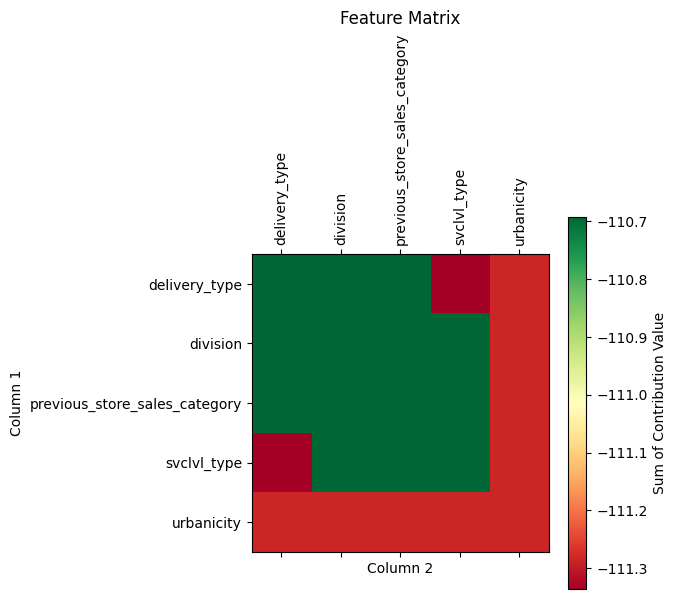

In [56]:
#Future section to build charts and tables
#
#///////////////////////////////////////////////////////////////////////
# CHARTS and TABLES
#///////////////////////////////////////////////////////////////////////
#
dfGraphs = pd.DataFrame()
dfGraphs = dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum().unstack(fill_value=0)

# plt.imshow(dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum(), cmap ="RdYlBu") 
  
plt.figure(figsize=(8, 6))
plt.matshow(dfGraphs, cmap='RdYlGn')  # You can choose a different colormap if desired
plt.xticks(range(len(dfGraphs.columns)), dfGraphs.columns, rotation=90)
plt.yticks(range(len(dfGraphs.index)), dfGraphs.index)
plt.xlabel('Column 2')
plt.ylabel('Column 1')
plt.title('Feature Matrix')
plt.colorbar(label='Sum of Contribution Value')
plt.show()



INDEX_2                                          A - NO_STORE_TXNS  B - 1-250  \
COLUMN_1                      INDEX_1                                           
delivery_type                 DELIVERY                   59.418365   6.992368   
                              DUG                      -121.156633 -23.880102   
division                      SOCAL                     -61.738269 -16.887733   
previous_store_sales_category A - NO_STORE_TXNS         -61.738269   0.000000   
                              B - 1-250                   0.000000 -16.887733   
                              C - 250-500                 0.000000   0.000000   
                              D - 500-1000                0.000000   0.000000   
                              E - 1000-1500               0.000000   0.000000   
                              F - 1500-3000               0.000000   0.000000   
                              G - 3000-15000              0.000000   0.000000   
                              H - 15000 +                 0.000000   0.000000   
svclvl_type                   EXPRESS                   -26.165510   0.612677   
                              FLASH                       4.600846  -1.607692   
                              STANDARD                  -40.173604 -15.892718   
urbanicity                    Rural                      -1.299561  -0.607238   
                              Suburban                  -57.593888  -6.306704   
                              Urban                      -3.189776 -10.132085   

INDEX_2                                          C - 250-500  D - 500-1000  \
COLUMN_1                      INDEX_1                                        
delivery_type                 DELIVERY             -0.638298     -2.008015   
                              DUG                 -10.231027      0.941763   
division                      SOCAL               -10.869325     -1.066252   
previous_store_sales_category A - NO_STORE_TXNS     0.000000      0.000000   
                              B - 1-250             0.000000      0.000000   
                              C - 250-500         -10.869325      0.000000   
                              D - 500-1000          0.000000     -1.066252   
                              E - 1000-1500         0.000000      0.000000   
                              F - 1500-3000         0.000000      0.000000   
                              G - 3000-15000        0.000000      0.000000   
                              H - 15000 +           0.000000      0.000000   
svclvl_type                   EXPRESS              -3.355809     -4.788168   
                              FLASH                -0.490027      6.660381   
                              STANDARD             -7.023488     -2.938465   
urbanicity                    Rural                -0.182668      1.868843   
                              Suburban             -6.454669     -3.968795   
                              Urban                -4.603006      1.442035   

INDEX_2                                           DELIVERY         DUG  \
COLUMN_1                      INDEX_1                                    
delivery_type                 DELIVERY           58.182961    0.000000   
                              DUG                 0.000000 -168.875409   
division                      SOCAL              58.182961 -168.875409   
previous_store_sales_category A - NO_STORE_TXNS  59.418365 -121.156633   
                              B - 1-250           6.992368  -23.880102   
                              C - 250-500        -0.638298  -10.231027   
                              D - 500-1000       -2.008015    0.941763   
                              E - 1000-1500       1.682765   -5.468139   
                              F - 1500-3000      -5.928366   -5.840727   
                              G - 3000-15000     -1.364936   -3.257038   
                              H - 15000 +         0.029079    0.016494   
svclvl_type    

<Figure size 600x600 with 0 Axes>

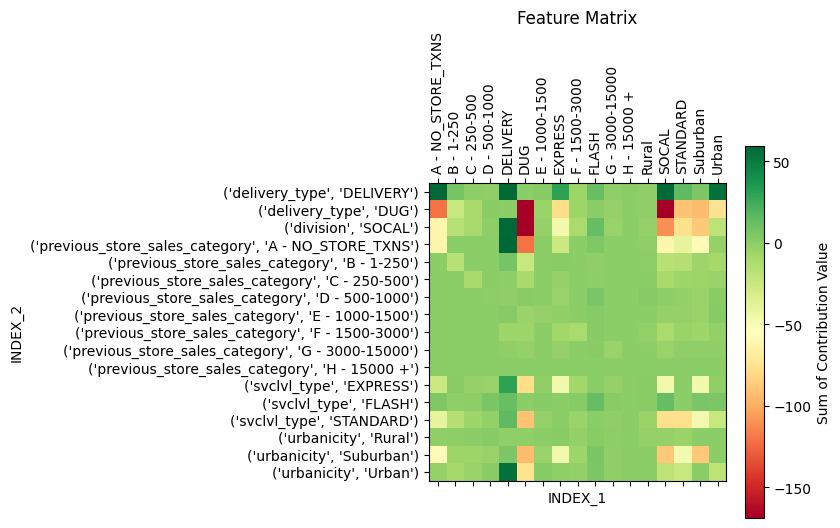

In [57]:
#Future section to build charts and tables
#
#///////////////////////////////////////////////////////////////////////
# CHARTS and TABLES
#///////////////////////////////////////////////////////////////////////
#
dfGraph_Lvl_2 = pd.DataFrame()
dfGraph_Lvl_2 = dfFINALOUTPUT.groupby(['COLUMN_1','INDEX_1', 'INDEX_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum().unstack(fill_value=0)
display(dfGraph_Lvl_2)
# plt.imshow(dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum(), cmap ="RdYlBu") 
  
plt.figure(figsize=(5, 5), dpi=120)
plt.matshow(dfGraph_Lvl_2, cmap='RdYlGn')  # You can choose a different colormap if desired
plt.xticks(range(len(dfGraph_Lvl_2.columns)), dfGraph_Lvl_2.columns, rotation=90)
plt.yticks(range(len(dfGraph_Lvl_2.index)), dfGraph_Lvl_2.index)
plt.xlabel('INDEX_1')
plt.ylabel('INDEX_2')
plt.title('Feature Matrix')
plt.colorbar(label='Sum of Contribution Value')
plt.show()


In [58]:
dfFINALOUTPUT[(dfFINALOUTPUT['COLUMN_1'] == 'division') & (dfFINALOUTPUT['COLUMN_2'] != 'division')]

,TOTAL_CONTRIBUTION_30_DAYS,TOTAL_CONTRIBUTION_60_DAYS,FEATURES,NUM_FEATURES,NUM_HH_FIRST_TIMEPERIOD,NUM_HH_LAST_TIMEPERIOD,VARIANCE,RPT_RATE_60_BPS_DIFF,60_DAY_RATE_CONTRIBUTION,60_DAY_MIX_CONTRIBUTION,INDEX,COLUMN_1,INDEX_1,INDEX_2,COLUMN_2
169,56.160916,58.182961,division::delivery_type,2,69879.0,57294,-0.056381,307.477392,77.844545,-19.661584,"(SOCAL, DELIVERY)",division,SOCAL,DELIVERY,delivery_type
172,13.987472,13.050405,division::svclvl_type,2,5167.0,17590,0.054838,-60.790738,-4.725079,17.775484,"(SOCAL, FLASH)",division,SOCAL,FLASH,svclvl_type
168,0.037005,0.045573,division::previous_store_sales_category,2,12.0,9,-0.000013,833.333333,0.033141,0.012432,"(SOCAL, H - 15000 +)",division,SOCAL,H - 15000 +,previous_store_sales_category
164,-0.094860,-1.066252,division::previous_store_sales_category,2,21729.0,20806,-0.004318,19.445200,1.787750,-2.854003,"(SOCAL, D - 500-1000)",division,SOCAL,D - 500-1000,previous_store_sales_category
174,-1.474736,-3.497259,division::urbanicity,2,15410.0,14939,-0.002251,-29.662179,-1.958080,-1.539179,"(SOCAL, Rural)",division,SOCAL,Rural,urbanicity
165,-5.641371,-3.785374,division::previous_store_sales_category,2,11098.0,9705,-0.006278,31.107990,1.334054,-5.119428,"(SOCAL, E - 1000-1500)",division,SOCAL,E - 1000-1500,previous_store_sales_category
167,-3.940452,-4.621974,division::previous_store_sales_category,2,2649.0,2115,-0.002389,-231.335791,-2.162017,-2.459957,"(SOCAL, G - 3000-15000)",division,SOCAL,G - 3000-15000,previous_store_sales_category
163,-5.856064,-10.869325,division::previous_store_sales_category,2,20738.0,21146,0.001574,-123.147889,-11.506972,0.637647,"(SOCAL, C - 250-500)",division,SOCAL,C - 250-500,previous_store_sales_category
166,-10.166558,-11.769093,division::previous_store_sales_category,2,11667.0,9368,-0.010287,-65.986495,-2.731541,-9.037551,"(SOCAL, F - 1500-3000)",division,SOCAL,F - 1500-3000,previous_store_sales_category
162,-11.499295,-16.887733,division::previous_store_sales_category,2,48412.0,52165,0.016050,-64.358414,-14.835097,-2.052636,"(SOCAL, B - 1-250)",division,SOCAL,B - 1-250,previous_store_sales_category


,INDEX_2,A - NO_STORE_TXNS,B - 1-250,C - 250-500,D - 500-1000,DELIVERY,DUG,E - 1000-1500,EXPRESS,F - 1500-3000,FLASH,G - 3000-15000,H - 15000 +,Rural,STANDARD,Suburban,Urban
COLUMN_1,INDEX_1,,,,,,,,,,,,,,,,
division,SOCAL,-61.738269,-16.887733,-10.869325,-1.066252,58.182961,-168.875409,-3.785374,-47.509711,-11.769093,13.050405,-4.621974,0.045573,-3.497259,-76.233142,-88.11573,-19.671135


<Figure size 600x600 with 0 Axes>

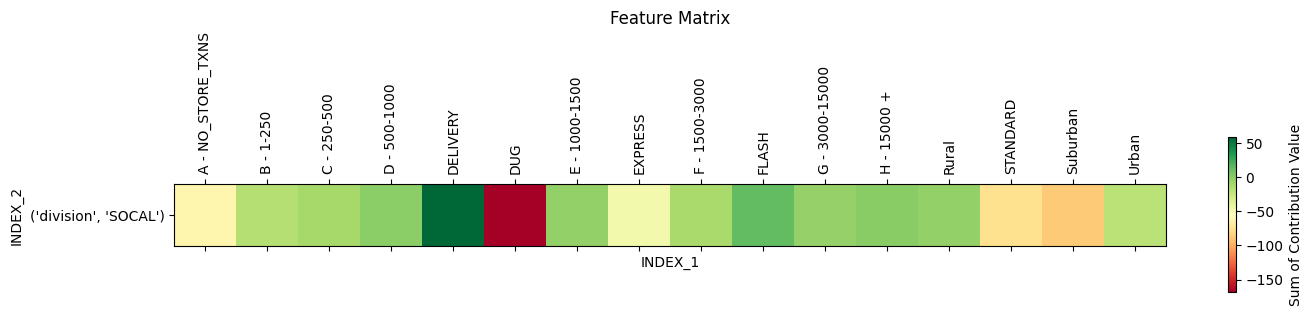

In [59]:
#
#///////////////////////////////////////////////////////////////////////
# DIVISION LEVEL
#///////////////////////////////////////////////////////////////////////
#
dfGraph_Lvl_3 = pd.DataFrame()
dfDIVISION = dfFINALOUTPUT[(dfFINALOUTPUT['COLUMN_1'] == 'division') & (dfFINALOUTPUT['COLUMN_2'] != 'division')]
dfGraph_Lvl_3 = dfDIVISION.groupby(['COLUMN_1','INDEX_1', 'INDEX_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum().unstack(fill_value=0)
display(dfGraph_Lvl_3)
# plt.imshow(dfFINALOUTPUT.groupby(['COLUMN_1', 'COLUMN_2'])['TOTAL_CONTRIBUTION_60_DAYS'].sum(), cmap ="RdYlBu") 
  
plt.figure(figsize=(5, 5), dpi=120)
plt.matshow(dfGraph_Lvl_3, cmap='RdYlGn')  # You can choose a different colormap if desired
plt.xticks(range(len(dfGraph_Lvl_3.columns)), dfGraph_Lvl_3.columns, rotation=90)
plt.yticks(range(len(dfGraph_Lvl_3.index)), dfGraph_Lvl_3.index)
plt.xlabel('INDEX_1')
plt.ylabel('INDEX_2')
plt.title('Feature Matrix')
plt.colorbar(label='Sum of Contribution Value')
plt.show()
